In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
data = pd.read_csv('D:/rech/VeriRu/words/dataset_fc_96.csv',header=None)
data = np.array(data)
# np.random.shuffle(data)

In [3]:
y = data[:,1344]
X = data[:,0:1344]

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
X_train.dtype, y_train.dtype

(dtype('float64'), dtype('float64'))

In [6]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [7]:
class RechNet(torch.nn.Module):
    def __init__(self, n_1,n_2):
        super(RechNet, self).__init__()
        
        torch.nn.BatchNorm1d(n_1)
        self.fc1 = torch.nn.Linear(96*14, n_1)
        torch.nn.Dropout(0.4)
        self.ac1 = torch.nn.Sigmoid()
        
        torch.nn.BatchNorm1d(n_2)
        self.fc2 = torch.nn.Linear(n_1, n_2) 
        torch.nn.Dropout(0.25)
        self.ac2 = torch.nn.Sigmoid()
#         self.fc3 = torch.nn.Linear(n_2, 10)
        
        torch.nn.BatchNorm1d(20)
        self.fc3 = torch.nn.Linear(n_2, 20) 
        torch.nn.Dropout(0.25)
        self.ac3 = torch.nn.Sigmoid()
        self.fc4 = torch.nn.Linear(20, 10) 

    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.fc4(x)        
        
        return x
    
rech_net = RechNet(60,40)

In [8]:
class RechNet(torch.nn.Module):
    def __init__(self, n_1,n_2):
        super(RechNet, self).__init__()
        
        torch.nn.BatchNorm1d(n_1)
        self.fc1 = torch.nn.Linear(96*14, n_1)
        torch.nn.Dropout(0.4)
        self.ac1 = torch.nn.Sigmoid()
        
        torch.nn.BatchNorm1d(n_2)
        self.fc2 = torch.nn.Linear(n_1, n_2) 
        torch.nn.Dropout(0.25)
        self.ac2 = torch.nn.Sigmoid()
        
        self.fc3 = torch.nn.Linear(n_2, 10) 

    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x
    
rech_net = RechNet(60,30)

In [9]:
# !nvidia-smi

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
rech_net = rech_net.to(device)
# list(rech_net.parameters())

In [11]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rech_net.parameters(), lr=3.0e-4)

In [12]:
test_accuracy_history = []
test_loss_history = []

batch_size = 100

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = rech_net.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
                
    test_preds = rech_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    if epoch % 30 == 0:
        print(accuracy)
    if accuracy>0.9:
        print(accuracy)
#         break

tensor(0.5170)
tensor(0.9150)
tensor(0.9171)
tensor(0.9150)
tensor(0.9193)
tensor(0.9253)
tensor(0.9313)
tensor(0.9365)
tensor(0.9356)
tensor(0.9365)
tensor(0.9399)
tensor(0.9442)
tensor(0.9425)
tensor(0.9446)
tensor(0.9476)
tensor(0.9489)
tensor(0.9502)
tensor(0.9493)
tensor(0.9459)
tensor(0.9480)
tensor(0.9476)
tensor(0.9532)
tensor(0.9532)
tensor(0.9536)
tensor(0.9502)
tensor(0.9562)
tensor(0.9566)
tensor(0.9562)
tensor(0.9562)
tensor(0.9511)
tensor(0.9562)
tensor(0.9558)
tensor(0.9541)
tensor(0.9575)
tensor(0.9601)
tensor(0.9528)
tensor(0.9579)
tensor(0.9584)
tensor(0.9605)
tensor(0.9562)
tensor(0.9579)
tensor(0.9592)
tensor(0.9614)
tensor(0.9592)
tensor(0.9614)
tensor(0.9626)
tensor(0.9626)
tensor(0.9614)
tensor(0.9592)
tensor(0.9545)
tensor(0.9605)
tensor(0.9605)
tensor(0.9618)
tensor(0.9588)
tensor(0.9657)
tensor(0.9618)
tensor(0.9626)
tensor(0.9592)
tensor(0.9562)
tensor(0.9562)
tensor(0.9618)
tensor(0.9605)
tensor(0.9571)
tensor(0.9639)
tensor(0.9558)
tensor(0.9639)
tensor(0.9

In [18]:
from sklearn.metrics import f1_score
a = y_test.data.cpu()
b = test_preds.argmax(dim=1).cpu()
f1_score(a,b,average='micro')

0.9660798626019751

[Text(0.5, 0, 'Эпохи обучения'), Text(0, 0.5, 'Accuracy')]

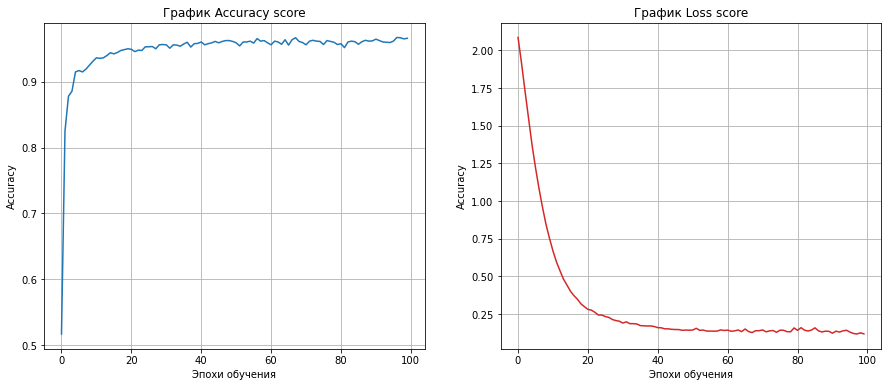

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
ax1.plot(test_accuracy_history,'tab:blue')
ax1.set_title('График Accuracy score')
ax1.grid()
ax1.set(xlabel='Эпохи обучения', ylabel='Accuracy')

ax2.plot(test_loss_history,'tab:red')
ax2.set_title('График Loss score')
ax2.grid()
ax2.set(xlabel='Эпохи обучения', ylabel='Accuracy')

# Cохранение модели

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in rech_net.state_dict():
    print(param_tensor, "\t", rech_net.state_dict()[param_tensor].size())

In [61]:
# Specify a path
PATH = "D:/rech/model/Kursach_fc_100_40.pt"

# Save
torch.save(rech_net.state_dict(), PATH)

# Load
# rech_net.load_state_dict(torch.load(PATH))
# rech_net.eval()


In [44]:
//////////////////////

SyntaxError: invalid syntax (<ipython-input-44-557c9ee46a7d>, line 1)

In [108]:
test = pd.read_csv('D:/rech/test_fc.csv',header=None)
test = np.array(test)
test = torch.FloatTensor(test)
test = test.to(device)

In [109]:
preds = rech_net.forward(test)

In [110]:
preds.argmax(dim=1)

tensor([2, 3, 4, 5, 7, 7, 8], device='cuda:0')

In [48]:
y

array([5., 8., 8., 1., 9., 2., 1., 1., 4., 8., 3., 5., 1., 6., 0., 7., 3.,
       4., 0., 7., 6., 5., 2., 3., 0., 2., 5., 8., 3., 6., 5., 0., 9., 6.,
       1., 9., 1., 7., 9., 8., 9., 8., 8., 6., 3., 2., 9., 1., 6., 6., 5.,
       9., 8., 1., 7., 4., 4., 1., 2., 2., 5., 4., 4., 1., 5., 0., 0., 1.,
       3., 3., 5., 3., 2., 3., 7., 5., 8., 9., 3., 9., 2., 8., 2., 3., 5.,
       7., 0., 0., 7., 6., 7., 2., 0., 7., 7., 3., 4., 7., 9., 4., 0., 4.,
       6., 5., 2., 9., 8., 6., 8., 4., 2., 7., 1., 9., 0., 6., 6., 0., 4.,
       4.])

In [111]:
6/7

0.8571428571428571